In [1]:
import os
import typing
import numpy as np
import ta as ta_lib
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt

pd.options.mode.use_inf_as_na = True

import quantstats as qs
qs.extend_pandas()

# filter warnings
import warnings
warnings.filterwarnings('ignore')

### 0. Get Daily OHLCV from YFinance

In [2]:
import yfinance as yf

symbol = 'CCRO3.SA'

df_daily = yf.download(symbol, period='2y', interval='1d').reset_index()

# Drop Adj Close
df_daily.drop(columns=['Adj Close'], inplace=True)

# Renaming Datetime column
df_daily = df_daily.rename(columns={'Datetime': 'Date'})

display(df_daily.tail())

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
490,2022-03-23,12.91,13.16,12.83,13.10,5061900
491,2022-03-24,13.46,14.11,13.25,14.08,20041500
492,2022-03-25,14.00,14.40,14.00,14.17,14978300
493,2022-03-28,14.13,14.25,13.90,13.97,8131900
494,2022-03-29,0.00,0.00,0.00,13.83,0


### 0.2 Get Hourly OHLC from YFinance

In [3]:
df_hourly = yf.download(symbol, period='2y', interval='60m').reset_index()

# Drop Adj Close
df_hourly.drop(columns=['Adj Close'], inplace=True)

# Renaming Datetime column
df_hourly = df_hourly.rename(columns={'Datetime': 'date'})

# 
df_hourly.set_index('date', inplace=True)

# Filter hours
hours = df_hourly.index.hour
df_hourly = df_hourly.iloc[((hours >= 11) & (hours < 17))]

df_hourly.index = df_hourly.index.tz_convert(None) - pd.Timedelta(hours=3)

display(df_hourly.tail(6))

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
date,,,,,
2022-03-29 11:00:00,13.93,13.98,13.80,13.81,2039100.0
2022-03-29 12:00:00,13.82,13.90,13.79,13.84,935700.0
2022-03-29 13:00:00,13.84,13.86,13.78,13.85,619000.0
2022-03-29 14:00:00,13.85,13.90,13.80,13.83,1089300.0
2022-03-29 15:00:00,13.83,13.91,13.82,13.90,912600.0
2022-03-29 16:00:00,13.90,13.94,13.85,13.85,1332400.0


### 0. Get OHLCV hourly from QFLib

In [4]:
# TODO

### Feature Engineering

In [5]:
def fix_dataset_inconsistencies(dataframe, fill_value=None):
    """TODO"""
    dataframe = dataframe.replace([-np.inf, np.inf], np.nan)

    # This is done to avoid filling middle holes with backfilling.
    if fill_value is None:
        dataframe.iloc[0,:] = dataframe.apply(lambda column: column.iloc[column.first_valid_index()], axis='index')
    else:
        dataframe.iloc[0,:] = dataframe.iloc[0,:].fillna(fill_value)
        
    return dataframe.fillna(axis='index', method='pad').dropna(axis='columns')

def rsi(price: 'pd.Series[pd.Float64Dtype]', period: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    r = price.diff()
    upside = np.minimum(r, 0).abs()
    downside = np.maximum(r, 0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    
    return 100 * (1 - (1 + rs) ** -1)

def macd(price: 'pd.Series[pd.Float64Dtype]', fast: float, slow: float, signal: float) -> 'pd.Series[pd.Float64Dtype]':
    """TODO"""
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def generate_all_default_quantstats_features(data):
    """TODO"""
    
    excluded_indicators = [
        'compare',
        'greeks',
        'information_ratio',
        'omega',
        'r2',
        'r_squared',
        'rolling_greeks',
        'warn'
    ]
    
    indicators_list = [f for f in dir(qs.stats) if f[0] != '_' and f not in excluded_indicators]
    
    df = data.copy()
    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)

    for indicator_name in indicators_list:
        try:
            print(indicator_name)
            indicator = qs.stats.__dict__[indicator_name](df['Close'])
            if isinstance(indicator, pd.Series):
                indicator = indicator.to_frame(name=indicator_name)
                df = pd.concat([df, indicator], axis='columns')
        except (pd.errors.InvalidIndexError, ValueError):
            pass

    df = df.reset_index()
    return df

def generate_features(data):
    """TODO"""
    # Automatically-generated using pandas_ta
    df = data.copy()

    strategies = ['candles', 
                  'cycles', 
                  'momentum', 
                  'overlap', 
                  'performance', 
                  'statistics', 
                  'trend', 
                  'volatility', 
                  'volume']

    df.index = pd.DatetimeIndex(df.index)

    cores = os.cpu_count()
    df.ta.cores = cores

#     for strategy in strategies:
#         df.ta.study(strategy)

    df = df.set_index('Date')

    # Generate all default indicators from ta library
    ta_lib.add_all_ta_features(data, 
                            'Open', 
                            'High', 
                            'Low', 
                            'Close', 
                            'Volume', 
                            fillna=True)
    
    data = data.set_index('Date')

    # Custom indicators
    features = pd.DataFrame.from_dict({
        'prev_open': data['Open'].shift(1),
        'prev_high': data['High'].shift(1),
        'prev_low': data['Low'].shift(1),
        'prev_close': data['Close'].shift(1),
        'prev_volume': data['Volume'].shift(1),
        'vol_5': data['Close'].rolling(window=5).std().abs(),
        'vol_10': data['Close'].rolling(window=10).std().abs(),
        'vol_20': data['Close'].rolling(window=20).std().abs(),
        'vol_30': data['Close'].rolling(window=30).std().abs(),
        'vol_50': data['Close'].rolling(window=50).std().abs(),
        'vol_60': data['Close'].rolling(window=60).std().abs(),
        'vol_100': data['Close'].rolling(window=100).std().abs(),
        'vol_200': data['Close'].rolling(window=200).std().abs(),
        'ma_5': data['Close'].rolling(window=5).mean(),
        'ma_10': data['Close'].rolling(window=10).mean(),
        'ma_20': data['Close'].rolling(window=20).mean(),
        'ma_30': data['Close'].rolling(window=30).mean(),
        'ma_50': data['Close'].rolling(window=50).mean(),
        'ma_60': data['Close'].rolling(window=60).mean(),
        'ma_100': data['Close'].rolling(window=100).mean(),
        'ma_200': data['Close'].rolling(window=200).mean(),
        'ema_5': ta_lib.trend.ema_indicator(data['Close'], window=5, fillna=True),
        'ema_10': ta_lib.trend.ema_indicator(data['Close'], window=10, fillna=True),
        'ema_20': ta_lib.trend.ema_indicator(data['Close'], window=20, fillna=True),
        'ema_60': ta_lib.trend.ema_indicator(data['Close'], window=60, fillna=True),
        'ema_64': ta_lib.trend.ema_indicator(data['Close'], window=64, fillna=True),
        'ema_120': ta_lib.trend.ema_indicator(data['Close'], window=120, fillna=True),
        'lr_open': np.log(data['Open']).diff().fillna(0),
        'lr_high': np.log(data['High']).diff().fillna(0),
        'lr_low': np.log(data['Low']).diff().fillna(0),
        'lr_close': np.log(data['Close']).diff().fillna(0),
        'r_volume': data['Close'].diff().fillna(0),
        'rsi_5': rsi(data['Close'], period=5),
        'rsi_10': rsi(data['Close'], period=10),
        'rsi_100': rsi(data['Close'], period=100),
        'rsi_7': rsi(data['Close'], period=7),
        'rsi_28': rsi(data['Close'], period=28),
        'rsi_6': rsi(data['Close'], period=6),
        'rsi_14': rsi(data['Close'], period=14),
        'rsi_26': rsi(data['Close'], period=24),
        'macd_normal': macd(data['Close'], fast=12, slow=26, signal=9),
        'macd_short': macd(data['Close'], fast=10, slow=50, signal=5),
        'macd_long': macd(data['Close'], fast=200, slow=100, signal=50)
    })

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, features], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # Revert naming convention
    data = data.rename(columns={'Open': 'open', 
                                'High': 'high', 
                                'Low': 'low', 
                                'Close': 'close', 
                                'Volume': 'volume'})

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    data = data.reset_index()
    
    # Revert naming convention
    data = data.rename(columns={'Date': 'date'})

    # Generate all default quantstats features
    df_quantstats = generate_all_default_quantstats_features(data)

    # Concatenate both manually and automatically generated features
    data = pd.concat([data, df_quantstats], axis='columns').fillna(method='pad')

    # Remove potential column duplicates
    data = data.loc[:,~data.columns.duplicated()]

    # A lot of indicators generate NaNs at the beginning of DataFrames, so remove them
    data = data.iloc[200:]
    data = data.reset_index(drop=True)

    data = fix_dataset_inconsistencies(data, fill_value=None)
    
    data.set_index('date', inplace=True)
    
    return data

In [6]:
data_daily = generate_features(df_daily)

adjusted_sortino
autocorr_penalty
avg_loss
avg_return
avg_win
best
cagr
calmar
common_sense_ratio
comp
compsum
conditional_value_at_risk
consecutive_losses
consecutive_wins
cpc_index
cvar
distribution
drawdown_details
expected_return
expected_shortfall
exposure
gain_to_pain_ratio
geometric_mean
ghpr
implied_volatility
kelly_criterion
kurtosis
max_drawdown
monthly_returns
outlier_loss_ratio
outlier_win_ratio
outliers
payoff_ratio
pct_rank
profit_factor
profit_ratio
rar
recovery_factor
remove_outliers
risk_of_ruin
risk_return_ratio
rolling_sharpe
rolling_sortino
rolling_volatility
ror
serenity_index
sharpe
skew
smart_sharpe
smart_sortino
sortino
tail_ratio
to_drawdown_series
ulcer_index
ulcer_performance_index
upi
value_at_risk
var
volatility
win_loss_ratio
win_rate
worst


In [7]:
data_daily.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,Volume,compsum,implied_volatility,outliers,pct_rank,remove_outliers,rolling_sharpe,rolling_sortino,rolling_volatility,to_drawdown_series
date,,,,,,,,,,,,,,,,,,,,,
2021-01-20,13.06,13.12,12.81,12.90,5211400,-1.480357e+08,136574500,-0.230856,-1.939910e+05,-0.832787,...,5211400,3.290083e+232,0.447973,14.84,46.666667,12.90,-0.386309,-0.585529,0.379088,-0.178344
2021-01-21,12.93,13.04,12.56,12.56,11136400,-1.591721e+08,125438100,-0.252521,-7.071876e+05,-0.711181,...,11136400,4.461352e+233,0.447973,14.84,30.000000,12.56,-0.661339,-0.991098,0.378956,-0.200000
2021-01-22,12.46,12.62,12.36,12.51,11000400,-1.574797e+08,114437700,-0.242405,-6.847354e+05,-0.732702,...,11000400,6.027287e+234,0.447973,14.84,30.000000,12.51,-0.773521,-1.156351,0.378113,-0.203185
2021-01-26,12.47,12.66,12.15,12.15,11316600,-1.687963e+08,103121100,-0.284946,-1.168914e+06,-0.383066,...,11316600,7.925882e+235,0.447973,14.84,15.000000,12.15,-0.885933,-1.315171,0.380050,-0.226115
2021-01-27,12.14,12.67,12.10,12.50,14221900,-1.630577e+08,117343000,-0.249464,-2.908302e+05,-0.080156,...,14221900,1.069994e+237,0.447973,14.84,27.500000,12.50,-0.684412,-1.023159,0.382279,-0.203822


In [8]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295 entries, 2021-01-20 to 2022-03-29
Columns: 148 entries, open to to_drawdown_series
dtypes: float64(145), int64(3)
memory usage: 343.4 KB


In [9]:
data_daily.shape

(295, 148)

In [10]:
data_daily = data_daily.resample('H').pad().shift()
data_daily.loc[:, ['open', 'high', 'low', 'close', 'volume']].index

DatetimeIndex(['2021-01-20 00:00:00', '2021-01-20 01:00:00',
               '2021-01-20 02:00:00', '2021-01-20 03:00:00',
               '2021-01-20 04:00:00', '2021-01-20 05:00:00',
               '2021-01-20 06:00:00', '2021-01-20 07:00:00',
               '2021-01-20 08:00:00', '2021-01-20 09:00:00',
               ...
               '2022-03-28 15:00:00', '2022-03-28 16:00:00',
               '2022-03-28 17:00:00', '2022-03-28 18:00:00',
               '2022-03-28 19:00:00', '2022-03-28 20:00:00',
               '2022-03-28 21:00:00', '2022-03-28 22:00:00',
               '2022-03-28 23:00:00', '2022-03-29 00:00:00'],
              dtype='datetime64[ns]', name='date', length=10393, freq='H')

In [11]:
df_hourly[['Open', 'High', 'Low', 'Close', 'Volume']].index

DatetimeIndex(['2020-03-30 11:00:00', '2020-03-30 12:00:00',
               '2020-03-30 13:00:00', '2020-03-30 14:00:00',
               '2020-03-30 15:00:00', '2020-03-30 16:00:00',
               '2020-03-31 11:00:00', '2020-03-31 12:00:00',
               '2020-03-31 13:00:00', '2020-03-31 14:00:00',
               ...
               '2022-03-28 13:00:00', '2022-03-28 14:00:00',
               '2022-03-28 15:00:00', '2022-03-28 16:00:00',
               '2022-03-29 11:00:00', '2022-03-29 12:00:00',
               '2022-03-29 13:00:00', '2022-03-29 14:00:00',
               '2022-03-29 15:00:00', '2022-03-29 16:00:00'],
              dtype='datetime64[ns]', name='date', length=2743, freq=None)

In [12]:
# Daily Technical Indicators
data_daily_hourly = data_daily.resample('H').pad().shift()

# Hourly Prices
# TODO: Merge do 'df_hourly' em 'data_daily_hourly'

# Filter 
hour = data_daily_hourly.index.hour
data_daily_hourly = data_daily_hourly.iloc[((hour >= 11) & (hour < 17))]

---

In [13]:
# hour = data.index.hour
# data.iloc[((hour >= 11) & (hour < 17))].tail(10)

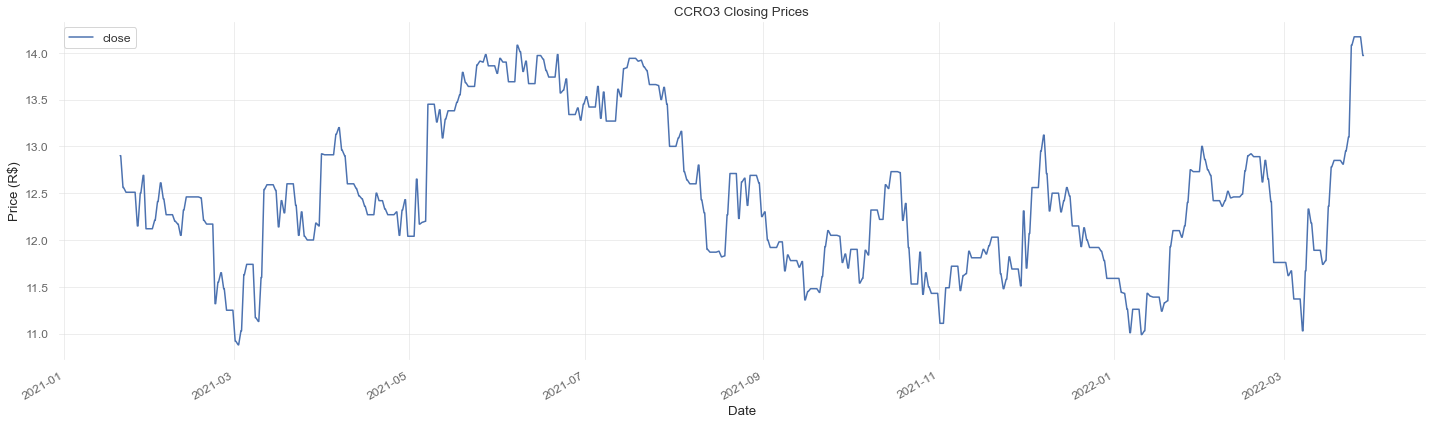

In [14]:
fig, ax = plt.subplots(figsize=(20,6))
data_daily_hourly.loc['2021':].close.plot(ax=ax)
ax.set_title(f'{symbol[:5]} Closing Prices')
ax.set_ylabel('Price (R$)')
ax.set_xlabel('Date')
plt.legend()
plt.tight_layout();